In [1]:
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import albumentations as A

We fix the random seed for visualization purposes, so the augmentation will always produce the same result. In a real computer vision pipeline, we might fix the random seed before applying a transform to the image because the pipeline will always output the same image. 

The purpose of image augmentation is to use different transformations each time.

This function is defined to apply either rain or snow effects to an image. It uses Albumentations to create the specific transformations depending on the effect type specified.

Here is the reference to helper functions: https://albumentations.ai/docs/examples/example_weather_transforms/

In [2]:
# Helper function to apply weather transformations
def apply_weather_effect(image, effect_type="rain"):
    if effect_type == "rain":
        transform = A.RandomRain(brightness_coefficient=0.9, drop_width=1, blur_value=3, p=1) # we can change the blur_value here to mimic the blurriness of camera under rainy/snowy weather 
    elif effect_type == "snow":
        transform = A.RandomSnow(brightness_coeff=2.5, snow_point_lower=0.3, snow_point_upper=0.5, p=1)
    transformed = transform(image=image)
    return transformed['image']

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


As each image is loaded and converted to RGB format, a random choice is made to determine whether to augment the image with rain, snow, or leave it as is (with respective probabilities of 25% for rain, 25% for snow, and 50% for no augmentation).

If an augmentation (rain or snow) is selected, the apply_weather_effect function is called with the current image and the selected effect type. The augmented image is then stored separately in augmented_images.

Additionally, the filename corresponding to each augmented image is stored in augmented_labels to maintain a link between the augmented images and their original labels.

In [4]:
# Load the image dataset
image_data_dir = "/content/drive/My Drive/CNN/Dataset/train_images"
image_filenames = os.listdir(image_data_dir)
image_data = []
augmented_images = []
augmented_labels = []

for filename in image_filenames:
    image_path = os.path.join(image_data_dir, filename)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Ensure image is in RGB
    if image is not None:
        image_data.append(image)
        # Decide randomly to augment image with rain or snow
        rand_effect = np.random.choice(["none", "rain", "snow"], p=[0.5, 0.25, 0.25])
        if rand_effect != "none":
            aug_image = apply_weather_effect(image, effect_type=rand_effect)
            augmented_images.append(aug_image)
            augmented_labels.append(filename)  # Assuming filename is enough to fetch labels

In [5]:
# Convert lists to NumPy arrays
image_data = np.array(image_data)
augmented_images = np.array(augmented_images)

# Load the labels and prepare full dataset
labels_data = pd.read_csv("/content/drive/My Drive/CNN/Dataset/labels.csv")
image_frame = pd.DataFrame({
    "image_filename": image_filenames + augmented_labels,
    "image_data": list(image_data) + list(augmented_images)
})
combined_data = pd.merge(labels_data, image_frame, on="image_filename")
X = np.stack(combined_data['image_data'])
y = to_categorical(combined_data["label"])

# Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

datagen.fit(X_train)

In [7]:
# Design the CNN model
model = Sequential()
model.add(Conv2D(128, kernel_size=(3, 3), activation="relu", input_shape=(image_data.shape[1:])))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(2, activation="softmax"))

In [8]:
# Compile the model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model on the augmented training dataset
### I pick 3 epochs just for a try. Should train more epochs!
model.fit(datagen.flow(X_train, y_train, batch_size=16), epochs=3, validation_data=(X_test, y_test))

Epoch 1/3
69/69 [==============================] - 98s 1s/step - loss: 28.9793 - accuracy: 0.5466 - val_loss: 2.1513 - val_accuracy: 0.5073
Epoch 2/3
69/69 [==============================] - 76s 1s/step - loss: 0.7409 - accuracy: 0.4835 - val_loss: 0.6916 - val_accuracy: 0.5620
Epoch 3/3
69/69 [==============================] - 79s 1s/step - loss: 0.6884 - accuracy: 0.5786 - val_loss: 0.6881 - val_accuracy: 0.5182


In [9]:
# Evaluate the model's performance on the testing dataset
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.6881400942802429
Test accuracy: 0.5182482004165649


Below I just want to visualize the results of augumentation. I will compare the same image before and after augumented with rain/snow effects.

In [12]:
# Function to visualize images
def visualize_images(images, titles, cols=2):
    rows = len(images) // cols
    plt.figure(figsize=(10, 5 * rows))
    for i, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image)
        plt.title(title)
        plt.axis("off")
    plt.show()

# Prepare to collect samples for visualization
visual_samples = []
visual_titles = []

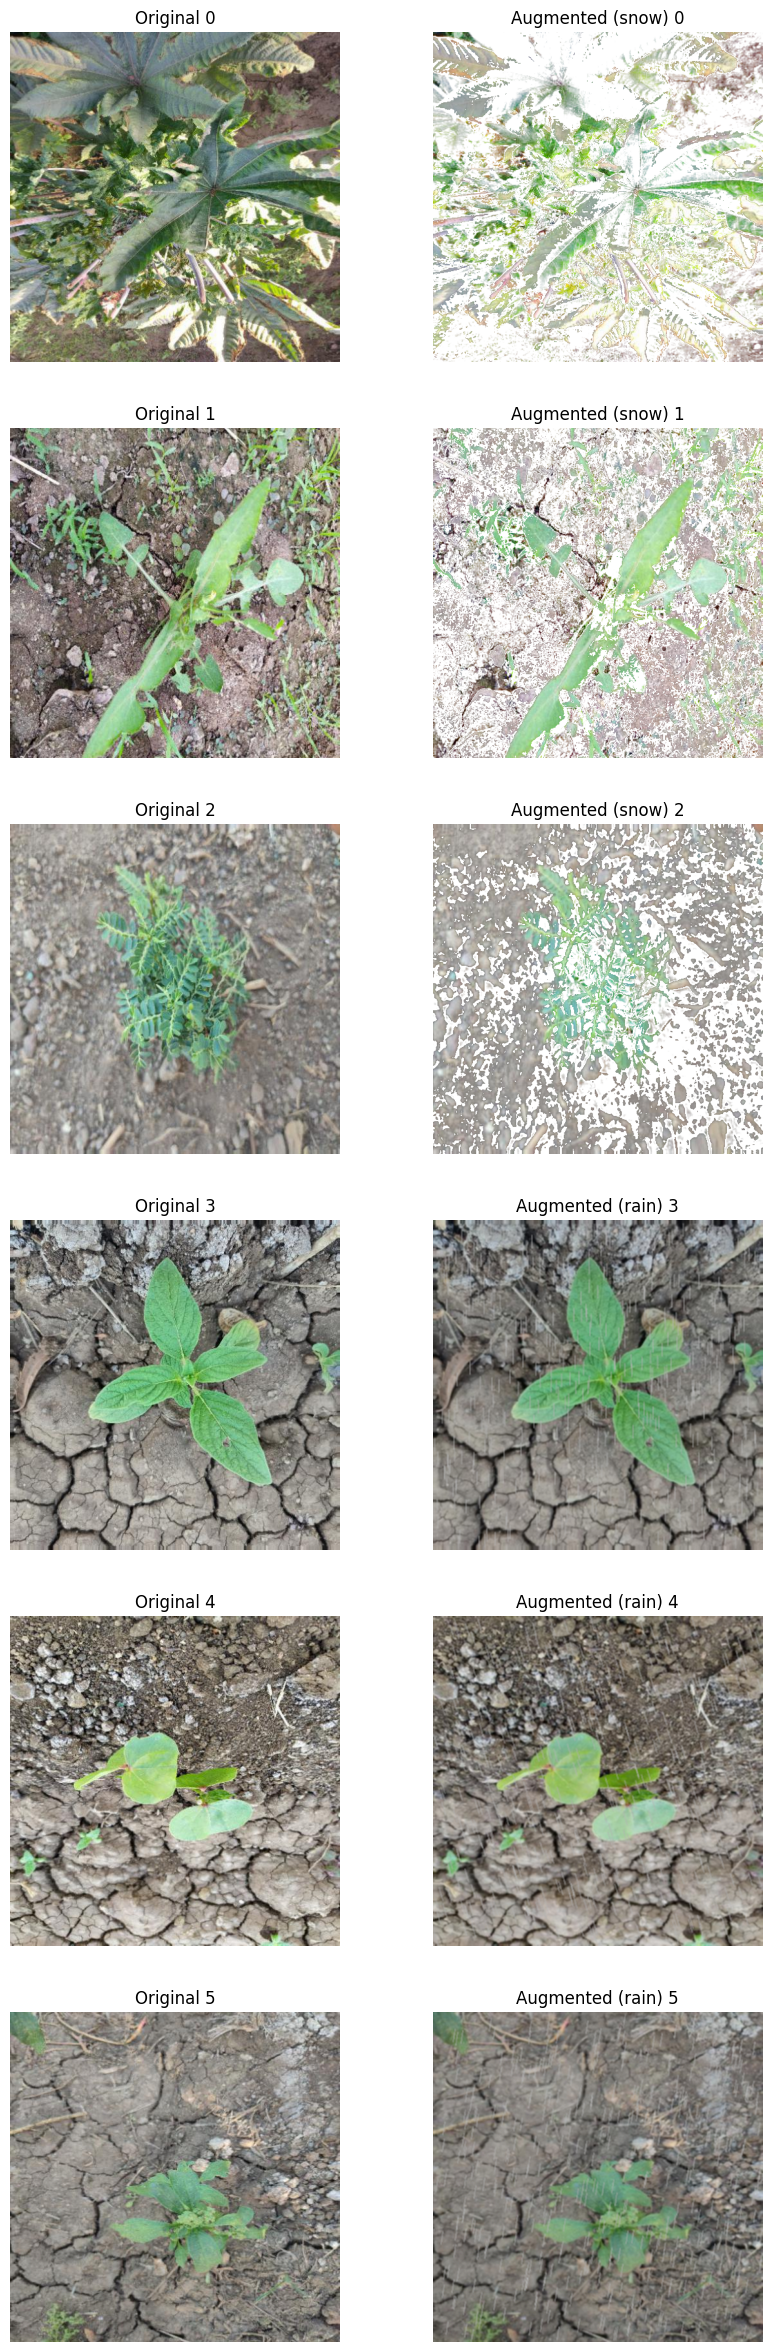

In [14]:
import random

# Loop over a small number of images for demonstration
for i, filename in enumerate(random.sample(image_filenames, 6)):  # Just take a small sample
    image_path = os.path.join(image_data_dir, filename)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    if image is not None:
        # Original image for comparison
        visual_samples.append(image)
        visual_titles.append(f"Original {i}")

        # Apply augmentation
        effect_type = random.choice(["rain", "snow"])
        aug_image = apply_weather_effect(image, effect_type=effect_type)
        visual_samples.append(aug_image)
        visual_titles.append(f"Augmented ({effect_type}) {i}")

# Visualize the collected samples
visualize_images(visual_samples, visual_titles, cols=2)